# Experiment fitting downward trend in data

Use shift in patient flows roughly from the start to end of March

In [226]:
# Modules needed
import numpy as np
import pandas as pd
import os, time
from plotnine import *
import plotnine
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from funs_support import cvec

dir_base = os.getcwd()
dir_flow = os.path.join(dir_base,'..','output','flow')
dat = pd.read_csv(os.path.join(dir_flow,'test.csv')).rename(columns={'index':'idx'})
thresh1 = dat[dat.tt=='train'].idx.max() + 1
thresh2 = dat.idx.max() + 1

y_train = dat[dat.tt == 'train'].y.values
y_test = dat[dat.tt != 'train'].y.values
x_train = dat[dat.tt == 'train'][['idx','hour']].values
x_test = dat[dat.tt != 'train'][['idx','hour']].values
x_extra = np.c_[thresh2 + np.arange(480),np.tile(np.arange(24), 20)]
enc = StandardScaler().fit(x_train)
x_train_til, x_test_til, x_extra_til = enc.transform(x_train), enc.transform(x_test), enc.transform(x_extra)

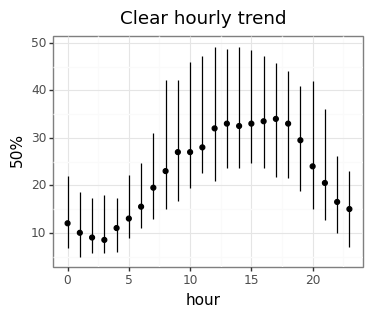

<ggplot: (8781119879005)>

In [41]:
df_hourly = dat.groupby('hour').y.describe().reset_index()
plotnine.options.figure_size = (4, 3)
gg_hourly = (ggplot(df_hourly, aes(x='hour', y='50%')) + 
             geom_point() + theme_bw() + 
             geom_linerange(aes(ymin='25%', ymax='75%')) + 
             ggtitle('Clear hourly trend'))
gg_hourly

In [242]:
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression

def nadarya(x, X, y, ll=0.5):
    """
    FUNCTION TO IMPLEMENT NADARYA-WATSON LINEAR SMOOTHER
    """
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T
    ytil = np.sum((w_gauss * cvec(y)), 0) / w_gauss.sum(0)
    return ytil
    
def local_reg(x, X, y, ll=0.5):
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T.flatten()
    #endog = x - X
    mdl = LinearRegression(fit_intercept=True).fit(X, y, w_gauss)
    return mdl.predict(x)

array([-6.70841293])

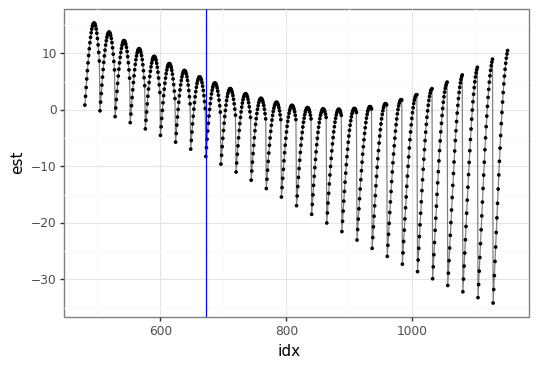

<ggplot: (8781112038977)>

In [240]:
local_test = np.array([local_reg(x_test_til[[z]], x_train_til, y_train, ll=1) for z in range(x_test.shape[0])])
local_extra = np.array([local_reg(x_extra_til[[z]], x_train_til, y_train, ll=1) for z in range(x_extra.shape[0])])
qq = pd.DataFrame({'idx':np.append(x_test[:,0],x_extra[:,0]),'est':np.append(local_test, local_extra)})
gg_local = (ggplot(qq, aes(x='idx',y='est')) + theme_bw() +
            geom_point(size=0.5) + geom_line(size=0.5, alpha=0.5) + 
            geom_vline(xintercept=thresh2,color='blue'))
gg_local

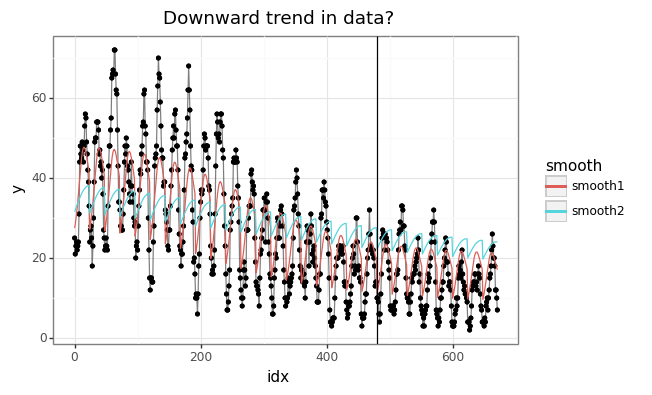

<ggplot: (8781111593645)>

In [186]:
smooth1 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=0.5)
smooth2 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=2.5)
tmp = dat.assign(smooth1=smooth1, smooth2=smooth2).melt(['idx','y','tt'],
                    ['smooth1','smooth2'],'smooth').assign(res=lambda x: x.y - x.value)

plotnine.options.figure_size = (6, 4)
gg_dat = (ggplot(tmp, aes(x='idx', y='y')) + 
          geom_point(size=1) + geom_line(size=0.5,alpha=0.5) + theme_bw() + 
          ggtitle('Downward trend in data?') + 
          geom_line(aes(x='idx',y='value',color='smooth'),data=tmp) + 
          geom_vline(xintercept=thresh1))
gg_dat

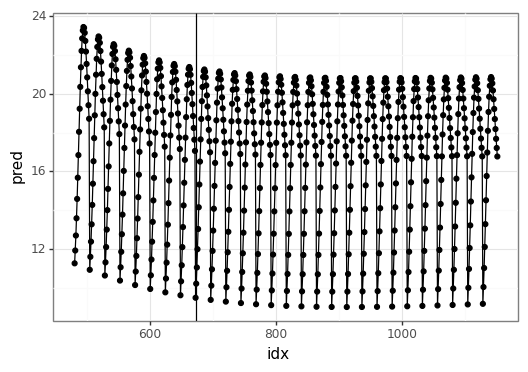

<ggplot: (8781112024529)>

In [201]:
smooth3 = nadarya(np.vstack([x_test_til, x_extra_til]), x_train_til, y_train, ll=0.50)
tmp2 = pd.DataFrame({'idx':np.r_[x_test[:,0],x_extra[:,0]],'pred':smooth3})
plotnine.options.figure_size = (6, 4)
gg_cont = (ggplot(tmp2, aes(x='idx',y='pred')) + geom_point() + 
           theme_bw() + geom_line() + 
           geom_vline(xintercept=thresh2))
gg_cont